이 Competition에서는, 120가지의 다른 개종류를 분류하는 작업을 하게 된다. 

여기서 사용된 dataset은 ImageNet dataset의 일부분이다. 

In [1]:
!pip install d2l

     |████████████████████████████████| 81kB 9.8MB/s 


In [2]:
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

## 13.14.1. Obtaining and Organizing the Dataset
competition dataset은 training set과 test set으로 나누어지는데, 각각 10222개와 10357개의 RGB channel로 이루어진 JPEG image로 구성되어 있다. training dataset은 120개의 종으로 이루어져 있다. (Labradors, Poodles, Dachshunds, Samoyeds, Huskies, Chihuahuas, and Yorkshire Terriers) 

### 13.14.1.1. Downloading the Dataset

d2l에서 제공하는 dataset의 작은 sample을 사용해서 학습을 해본다.



In [3]:
d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip', '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')

demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

### 13.14.1.2 Organizing the Dataset

original training set에서 validation set을 분리시키고, label들로 그룹화시킨 subfolder들로 image들을 이동시킨다.
reorg_dog_data function은 training data label들을 읽고, validation set으로 나누고, training set을 구성한다.

In [4]:
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 4 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

## 13.14.2 Image Augmentation

이 dog breed dataset은 ImageNet dataset의 subset이고, 여기 image들은 CIFAR-10 dataset의 image들보다 크다. 

아래는 상대적으로 큰 image들에 유용한 몇몇 image augmentation operation들을 소개한 것이다.  

In [5]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

prediction을 하는 동안 image preprocessing operation들을 random하지 않게 사용한다.

In [6]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

## 13.14.3 Reading the Dataset

raw image file들로 구성된 organized dataset

In [7]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir,'train_valid_test',folder),
        transform=transform_train) for folder in ['train','train_valid']]
valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid','test']]

In [8]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]
valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False, drop_last=True)
test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False, drop_last=False)

## 13.14.4 Fine-Tuning Pretrained Model

여기서 사용된 dataset이 ImageNet dataset의 일부분이기 때문에, ImageNet dataset 전체에 대해서 pretrain된 model을 고르고 좀 더 작은 scale의 output network에 넣기 위한 image feature들을 추출하기 위해서 사용한다. 

Deep learning framework의 High-level API들은 ImageNet dataset에서 사전 학습된 model들을 제공한다. 여기서 우리는 사전학습된 ResNet-34 model을 선택하고 이 model의 output layer를 쉽게 재사용할 수 있다. 그리고나서 우리는 original output layer를 학습될 수 있는 작은 custom output network (fc layer를 2개 stacking한 것과 같은)로 바꿀 수 있다. 

**Standardization operation by the pretrained model on ImageNet**

In [9]:
def get_net(devices):
    finetune_net = nn.Sequential()
    finetune_net.features = torchvision.models.resnet34(pretrained=True)
    # Define a new output network (120 output categories)
    finetune_net.output_new = nn.Sequential(nn.Linear(1000,256), nn.ReLU(), nn.Linear(256, 120))
    # Move the model to devices
    finetune_net = finetune_net.to(devices[0])
    # Freeze parameters of feature layers
    for param in finetune_net.features.parameters():
        param.requires_grad = False
    return finetune_net 

loss이 계산하기 전에, 첫번째 pretrained model의 output layer의 input(extracted feature)을 포함한다. 

그리고나서 우리는 이 feature를 loss를 계산하기 위해서 small custom output network에 input으로 사용한다.

In [10]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]),labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum = l.sum()
        n += labels.numel()
    return l_sum / n

## 13.14.5 Defining the Training Function

model을 고르고 validation set의 model performance에 따라서 hyperparameter들을 tuning한다. 

model training function train은 small custom output network의 parameter들만 iterate한다. 

In [11]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    # Only train the small custom output network
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD(
        (param for param in net.parameters() if param.requires_grad), lr=lr, momentum=0.9, weight_decay=wd
    )
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'valid loss'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i+1) % (num_batches // 5) == 0 or i == num_batches-1:
                animator.add(epoch+(i+1) / num_batches, (metric[0] / metric[1], None))        
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch+1, (None, valid_loss))
        scheduler.step()
    if valid_iter is not None:
        print(f'train loss {metric[0] / metric[1]:.3f},'
            f'valid loss {valid_loss:.3f}')
    else:
        print(f'train loss {metric[0] / metric[1]:.3f}')
    print(f'{metric[1] * num_epochs / timer.sum():.1f} examples/sec'
        f'on {str(devices)}')


train loss 3.164,valid loss 0.170
240.5 examples/secon [device(type='cuda', index=0)]


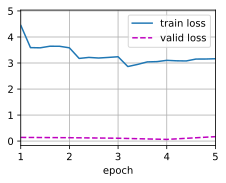

In [12]:
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 5, 0.001, 1e-4
lr_period, lr_decay, net = 10, 0.1, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

## 13.14.7 Classifying the Testing Set and Submitting Results on Kaggle

마지막으로, 모든 labeled data는 model을 training하고 testing set을 classifying하는데 사용이 된다. 

분류 작업을 위해서 학습된 custom output network를 사용할 것이다. 

train loss 3.228
223.7 examples/secon [device(type='cuda', index=0)]


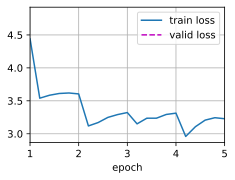

In [13]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])),dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('submission.csv','w') as f:
    f.write('id,'+','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(i.split('.')[0] + ',' + ','.join([str(num) for num in output]) + '\n')